<a href="https://colab.research.google.com/github/evdelph/MongoDB/blob/main/RedditVisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install plotly>=4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [ ]:
! pip install pyLDAvis==2.1.2

In [3]:
import pandas as pd
import numpy as np
import json
import nltk
import gensim
nltk.download('stopwords')
from nltk.corpus import stopwords 
stop_words = list(stopwords.words('english')) 
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim
import IPython
from pprint import pprint
import gensim.corpora as corpora
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



In [4]:
# extend stopwords
stop_words.extend(['get','got',"i'd","800","i", "me", "my", "myself", "we", "our", "ours", 
                   "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", 
                   "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", 
                   "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", 
                   "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", 
                   "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", 
                   "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", 
                   "with", "about", "against", "between", "into", "through", "during", "before", "after", 
                   "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", 
                   "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", 
                   "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", 
                   "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don",
                   "should", "now", "dont","don't","www","https","etc","i’d","id","1st","thats","make","makes",
                   "making","take","taking","772"])

### Part 1: Import data

Load in data from scp file transfers in the form of pandas dataframes

In [5]:
posts = pd.read_csv('posts.csv')
posts.head(3)

,body,score
0,Just wanted to update with my personal experie...,23
1,"I’m currently on Emgality monthly, with topira...",24
2,Anyone have experience with a CGRP that was wo...,16


In [6]:
replies = pd.read_csv('replies.csv')
replies.head(3)

,replies,score
0,"[{""comment_1"":""That’s great. I hope it continu...",23
1,"[{""comment_1"":""As a nurse, Im sure this is inf...",24
2,"[{""comment_1"":""Yes. This is what happened to m...",16


### Part 2: Cleanse data
Convert 'replies' dataframe into a more useable format. Cleanse both datasets of special characters, whitespaces, and convert to lowercase.

In [7]:
# function to cleanse data
def cleanse_text(df,col):
  """
  Remove stopwords
  Remove special characters
  """
  spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–","\xa0","\xa0å","”","“","’"]

  for char in spec_chars:
      df[col] = df[col].str.replace(char, ' ').str.replace('  ',' ').str.lower().str.strip()

  doc = []

  for sentence in df[col]:
    sentence = sentence.split(" ")
    for word in sentence:
      if word not in stop_words and len(word) >= 3:
        doc.append(word.strip())

  return doc

In [8]:
replies_cleansed = pd.DataFrame(columns=['Comments'])

comment_list = []
for reply in replies.replies:
  comments = json.loads(reply)
  for comment in comments:
    comment_list.append(" ".join(list(comment.values())))

replies_cleansed['Comments'] = comment_list
replies_cleansed.head(3)

,Comments
0,That’s great. I hope it continues to work so w...
1,"As a nurse, Im sure this is info youre well aw..."
2,Yes. This is what happened to me. Each of the ...


### Part 3: Perform NLTK on Unigrams
This will be used to analyze and visualize most frequent words from 1000 cgrpMigraine subreddit posts and comments.

In [9]:
# feed dataframes through text cleansing functions
post_doc = cleanse_text(posts,'body')
replies_doc = cleanse_text(replies_cleansed,'Comments')

# convert in dictionary form
docs = [post_doc,replies_doc]
dictionary = gensim.corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]

# compute frequencies
tfidf = gensim.models.TfidfModel(corpus)
post_bow = pd.Series({dictionary[id]:np.around(freq, decimals=2) for id, freq in tfidf[corpus[0]]}).to_frame()
replies_bow = pd.Series({dictionary[id]:np.around(freq, decimals=2) for id, freq in tfidf[corpus[1]]}).to_frame()

post_bow.columns = ['Frequency']
replies_bow.columns = ['Frequency']

In [10]:
# store top 50 most frequent words from comments
post_top_50 = post_bow.sort_values(by='Frequency',ascending=False).iloc[0:51,:]
post_top_50.head(3)

,Frequency
lupus,0.24
induced,0.17
topiramate,0.17


In [11]:
# store top 50 most frequent words from replies
replies_top_50 = replies_bow.sort_values(by='Frequency',ascending=False).iloc[0:51,:]
replies_top_50.head(3)

,Frequency
belly,0.27
thigh,0.23
thank,0.23


### Part 4: Perform NLTK functions on bigrams
This will be used to analyze and visualize bigrams (pair of two words) from 1000 cgrpMigraine subreddit posts and comments.

In [12]:
# compute bigrams on tokens
post_bigrams = list(nltk.bigrams(cleanse_text(posts,'body')))
replies_bigrams = list(nltk.bigrams(cleanse_text(replies_cleansed,'Comments')))

In [13]:
list(post_bigrams)[0:5]

[('wanted', 'update'),
 ('update', 'personal'),
 ('personal', 'experience'),
 ('experience', 'far'),
 ('far', 'posted')]

In [14]:
list(replies_bigrams)[0:5]

[('great', 'hope'),
 ('hope', 'continues'),
 ('continues', 'work'),
 ('work', 'well'),
 ('well', 'took')]

In [15]:
# for every word, compute frequency distribution of bigrams
post_freq_dist = nltk.ConditionalFreqDist(post_bigrams)
replies_freq_dist = nltk.ConditionalFreqDist(replies_bigrams)

# Part 5: Visualize Most Frequent Unigrams
Visualize unigram word frequencies from posts and replies using plotly library.

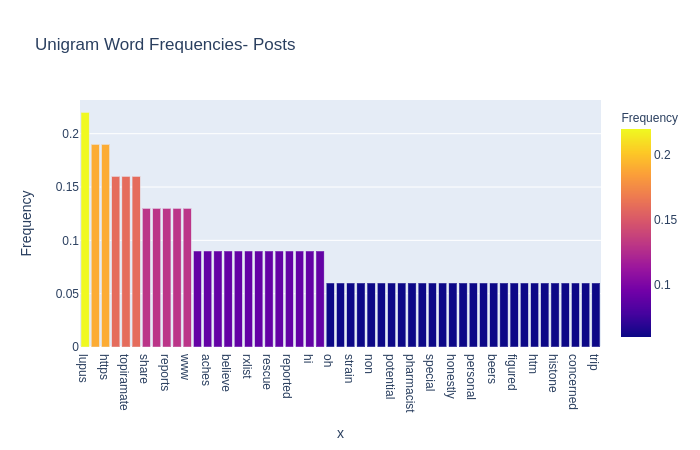

In [ ]:
fig = px.bar(post_top_50, x=post_top_50.index, y="Frequency",color="Frequency",title="Unigram Word Frequencies- Posts")
fig.show("png")

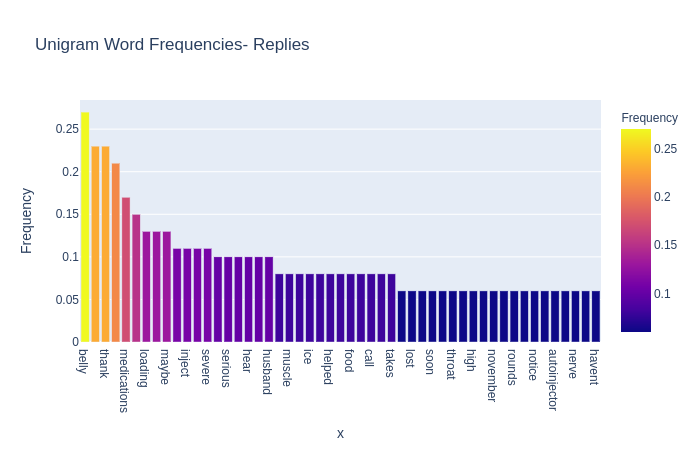

In [ ]:
fig = px.bar(replies_top_50, x=replies_top_50.index, y="Frequency",color="Frequency",title="Unigram Word Frequencies- Replies")
fig.show("png")

### Part 6- Visualize Bigram Frequencies
The bigram frequency distribution stores all the word associations in the form of a nested dictionary. I will visualize some interesting key words to see what other words they are associated with.

There are three cgrp autoinjector medications: Aimovig, Emgality, and Ajovy. For every drug (word), I will visualize bigrams for each word, for both posts and replies.

#### Aimovig Post and Replies Bigrams

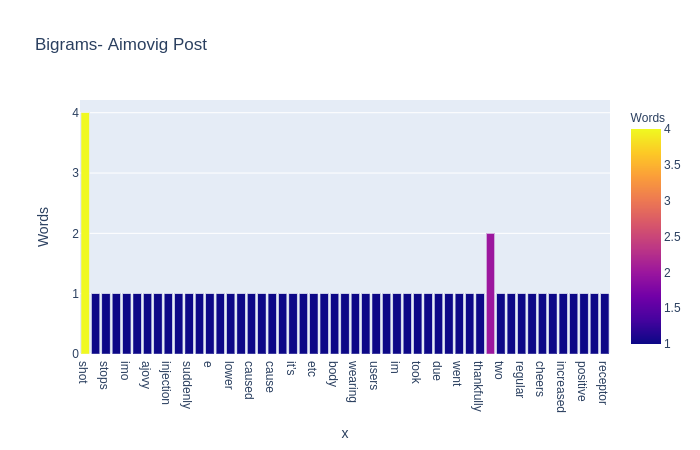

In [ ]:
# convert selected bigrams into dataframes
aimovig_post = pd.Series(dict(post_freq_dist['aimovig'])).to_frame()
aimovig_post.columns = ['Words']
fig = px.bar(aimovig_post, x=aimovig_post.index, y='Words',color='Words',title="Bigrams- Aimovig Post")
fig.show("png")

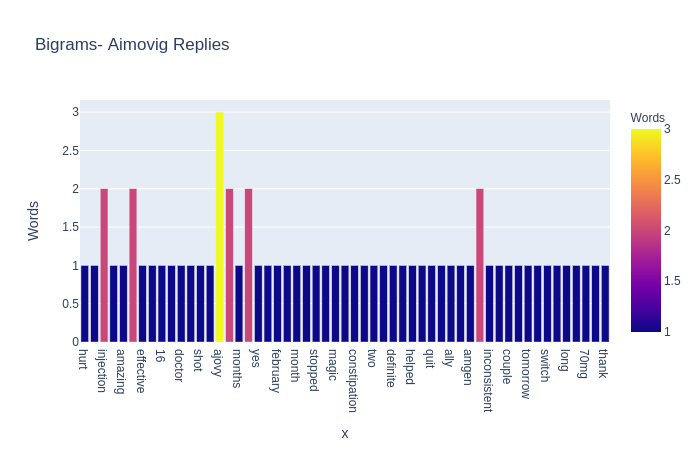

In [ ]:
# convert selected bigrams into dataframes
aimovig_replies = pd.Series(dict(replies_freq_dist['aimovig'])).to_frame()
aimovig_replies.columns = ['Words']
fig = px.bar(aimovig_replies, x=aimovig_replies.index, y='Words',color='Words',title="Bigrams- Aimovig Replies")
fig.show("png")

#### Emgality Post and Replies Bigrams

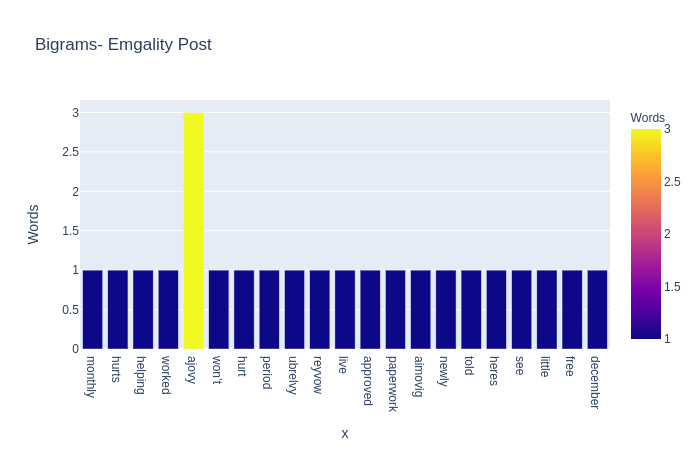

In [ ]:
# convert selected bigrams into dataframes
emgality_post = pd.Series(dict(post_freq_dist['emgality'])).to_frame()
emgality_post.columns = ['Words']
fig = px.bar(emgality_post, x=emgality_post.index, y='Words',color='Words',title="Bigrams- Emgality Post")
fig.show("png")

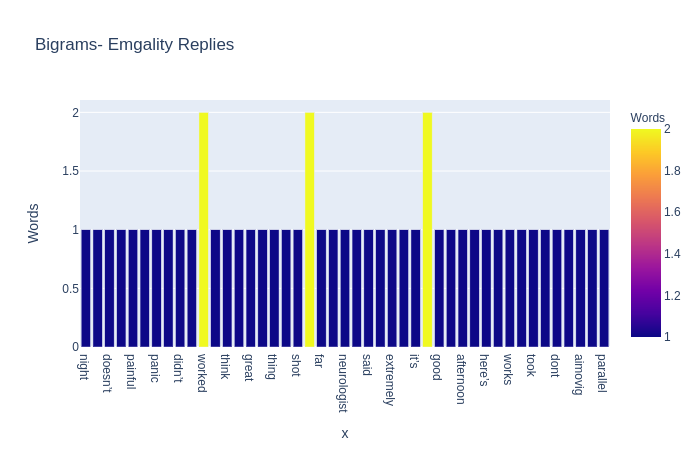

In [ ]:
# convert selected bigrams into dataframes
emgality_replies = pd.Series(dict(replies_freq_dist['emgality'])).to_frame()
emgality_replies.columns = ['Words']
fig = px.bar(emgality_replies, x=emgality_replies.index, y='Words',color='Words',title="Bigrams- Emgality Replies")
fig.show("png")

#### Ajovy Post and Replies Bigrams

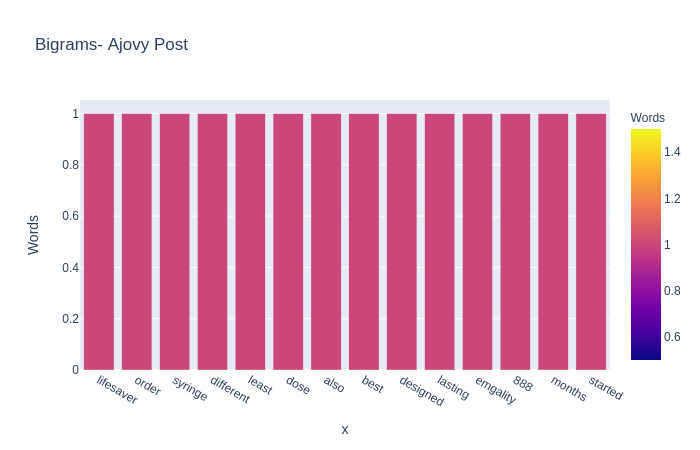

In [ ]:
# convert selected bigrams into dataframes
ajovy_post = pd.Series(dict(post_freq_dist['ajovy'])).to_frame()
ajovy_post.columns = ['Words']
fig = px.bar(ajovy_post, x=ajovy_post.index, y='Words',color='Words',title="Bigrams- Ajovy Post")
fig.show("png")

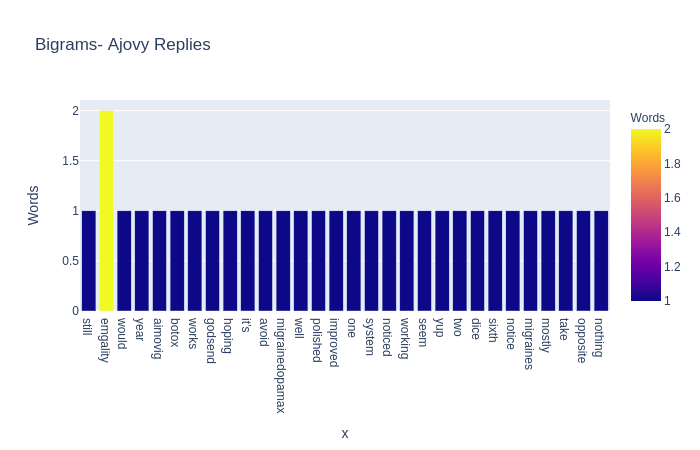

In [ ]:
# convert selected bigrams into dataframes
ajovy_replies = pd.Series(dict(replies_freq_dist['ajovy'])).to_frame()
ajovy_replies.columns = ['Words']
fig = px.bar(ajovy_replies, x=ajovy_replies.index, y='Words',color='Words',title="Bigrams- Ajovy Replies")
fig.show("png")

### Part 7: LDA Modeling

LDA is an unsupervised clustering algorithm that classifies words in a document as a topic. It assumes a multi-nominal distribution, where the words in the document are assumed to be related to one another. I took the extra step to stem and lemmatize the words in the post and replies document. I had LDA cluster the documents into five categories. Below shows the steps and results.

#### LDA Modeling for Posts


In [16]:
# https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925
# https://www.datacamp.com/community/tutorials/stemming-lemmatization-python

# lemmatize and stem the words
def lemmatize_stemming(doc):
    stemmer = SnowballStemmer("english",ignore_stopwords=True)
    return [stemmer.stem(word) for word in doc if len(word) >= 3]

processed_post_doc = lemmatize_stemming(post_doc)

In [17]:
print('preprocessed:',processed_post_doc[0:5], '\nnon-processed:',post_doc[0:5])

preprocessed: ['want', 'updat', 'person', 'experi', 'far'] 
non-processed: ['wanted', 'update', 'personal', 'experience', 'far']


In [18]:
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
# prepare corpus
id2word = corpora.Dictionary([processed_post_doc])
texts = processed_post_doc
corpus = [id2word.doc2bow(text.split()) for text in texts]

In [ ]:
# run LDA
num_topics = 5
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
doc_lda = lda_model[corpus]

In [ ]:
# https://stackoverflow.com/questions/60598837/html-to-image-using-python/60598918
# output results
output = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(output, 'lda_posts.html')
IPython.display.HTML(filename="lda_posts.html")

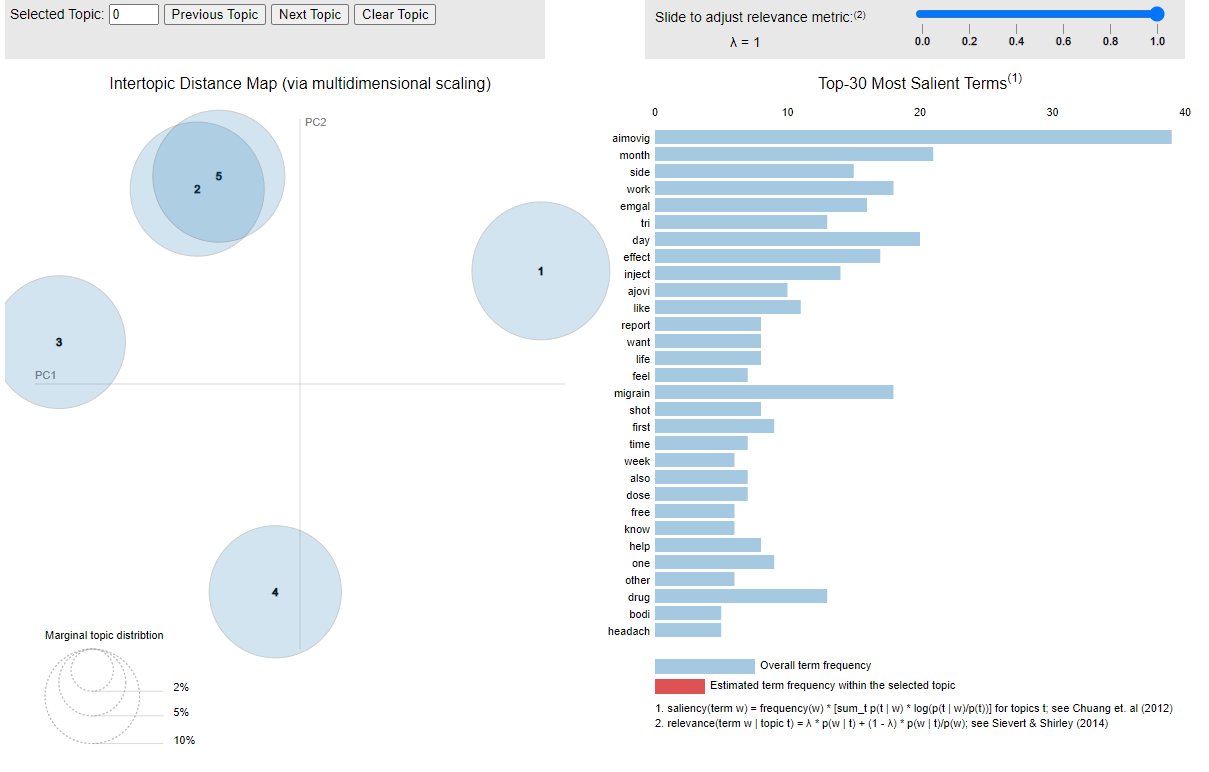

#### LDA Modeling for Replies

In [21]:
# lemmatize and stem replies
processed_replies_doc = lemmatize_stemming(replies_doc)
print('preprocessed:',processed_replies_doc[0:5], '\nnon-processed:',replies_doc[0:5])

preprocessed: ['great', 'hope', 'continu', 'work', 'well'] 
non-processed: ['great', 'hope', 'continues', 'work', 'well']


In [22]:
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
# prepare corpus
id2word2 = corpora.Dictionary([processed_replies_doc])
texts2 = processed_replies_doc
corpus2 = [id2word.doc2bow(text.split()) for text in texts2]

In [ ]:
# run LDA
num_topics = 3
lda_model2 = gensim.models.LdaMulticore(corpus=corpus2,
                                       id2word=id2word2,
                                       num_topics=num_topics)

doc_lda2 = lda_model2[corpus]

In [ ]:
output2 = pyLDAvis.gensim.prepare(lda_model2, corpus2, id2word2)
pyLDAvis.save_html(output2, 'lda_replies.html')
IPython.display.HTML(filename='lda_replies.html')

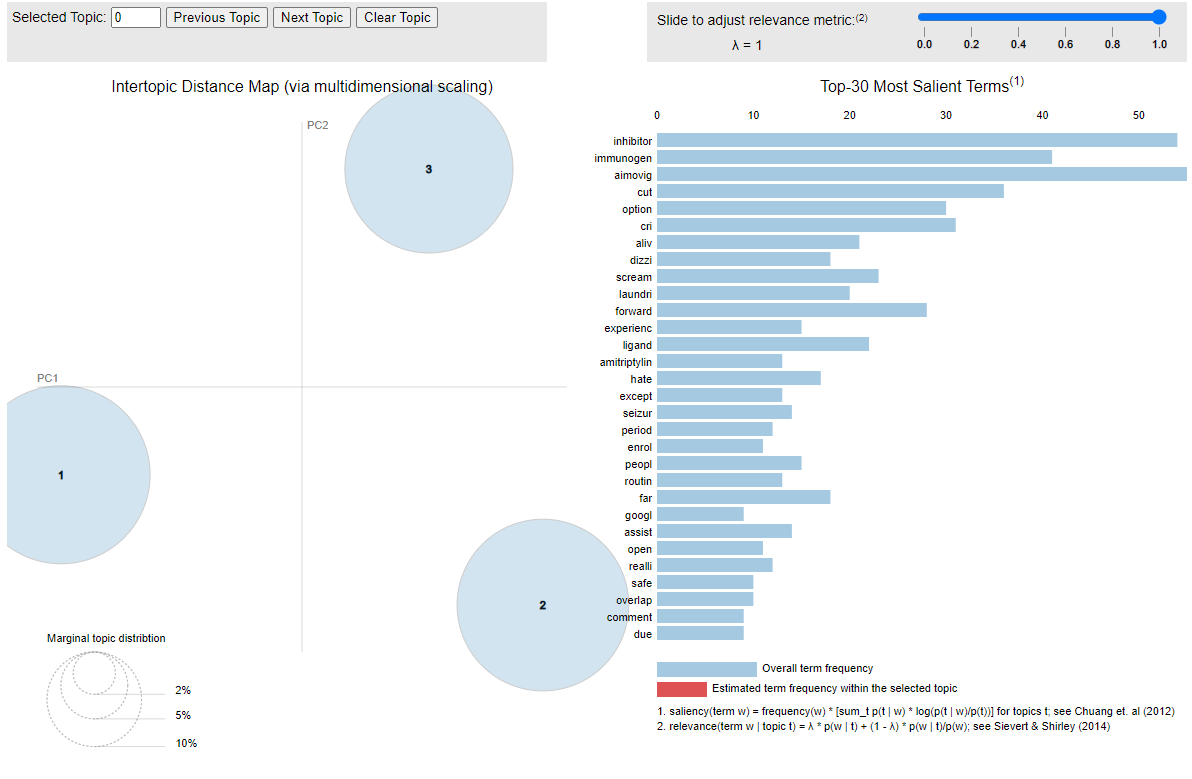

### Part 8: Brief Analysis of Results

#### Unigrams and bigrams

#### Unigram Word Frequencies

1. Posts: A variety of words appear. I notice words indicating sharing a narrative "share, reports, gave, believe, saying, etc" frequently occur in posts. Migraine related words like "topiramate, aches, dizziness, etc" are common as well.

2. Replies: More descriptive words of using cgrp medications like "belly, thigh, loading, etc" pertain to how patients inject themselves monthly.

#### Bigrams

1. Aimovig posts: Many words are about "shots and first", meaning the first on-loading dose. 

2. Aimovig replies: Personal experience from Aimovig, how it worked "amazing, worked" and injections "injections, switched"

3. Emgality posts: Mainly mentions a competing drug of Ajovy

4. Emgality replies: Mentions words like "pain, panic, painful" and injections

5. Ajovy posts: A collection of words including "lifesaver, Emgality, syringe, etc". No distinct pattern.

6. Ajovy replies: Mainly mentions the drug Emgality

#### LDA

LDA clusters for posts: 

1. Clusters 2 and 5: Related to the onboarding injection of Aimovig. Cluster 2 seems to be related to the semantics self-injections and cluster 5 is related to receiving consultations from physicians.

2. Cluster 3: Pertains to side effects

3. Cluster 4: Side effects in comparision to other migraine treatments (botox, emgality)

4. Cluster 1: Effectiveness of Aimovig

LDA clusters for replies:

1. Cluster 1: Appears to indiciate emotional reactions to cgrp experiences

2. Cluster 2: Mentions several types of migraine remedies (amitriptylin aimovig, botox, inhibitor, eremerg). Also mentions experiences and descriptive words about the effects of drugs.

3. Cluster 3: Seems to categorize questions surrounding the drug, such as "clarify, nurse, safe, question, and covid"